### Introduction to Preprocessing and Training Stage (Hard Court Version)

The goal of this stage is to create a training-testing split in the predictive features and target feature (% total points won by a given player in a given match), and to create a few simple benchmark models against which the more complex models will be compared in terms of prediction accuracy. 

Prediction is to be carried out at the player level for a given match (so each match in the sample has two records associated with it). Performance features used for prediction of a given player's % pts won in a given match are accrued based on  surface-specific (with a few exceptions) match data in matches PRIOR TO BUT NOT INCLDING the match being predicted nor any subsequent matches. 

The large majority of features included in the modeling stage are "differential", meaning that their values result from subtraction of previously calculated values for each of the two players in the match being predicted (Player X - Player Y or Player Y - Player X). As a simple example (actual features are typically adjusted in a number of ways before this stage) if Player X won 55% of his previous service points and his opponent (Player Y) won 47% of his own serve points the "differential" feature value "player_past_service_pts_diff" for Player X would be 55 - 47 = 8% and for Player Y would be 47 - 55 = -8%.  

Based on the results of prevous modeling iterations, data from the years 2015-2019 are currently included in the hard court-specific model, with an additional prior 3 years (2012-2014) used in statistical accrual for feature generation. Also, a threshold of minimum of 20 prior matches for BOTH players in a given match to be predicted is employed. Not surprisingly, prediction accuracy is sensitive to the amount of data available to generate predictive features, as well as to the amount of data available to train and test the model. Critically, matches filtered out at the current point and beyond (ie, during modeling) WERE used during statistical accruals for feature generation. Also of note, matches which lasted fewer than 12 games were filtered out BEFORE statistical accruals for feature generation. 
        

Four simple linear benchmarking models are created below:
* 1) A "dummy" model, which simply uses the mean of the training data split to predict the target of % points won by a given player in a given match
* 2) A multivariate linear model that uses as predictive features only 1- difference in ranking between the two players, 2- difference in log of the rankings of the two players, and 3- difference in rankings points between the two players. Given that tournament entry and seeding are determined primarily by ranking data by the tour itself, this simple model can very prudently be seen as a fair benchmark for any system hoping to predict player performance on a move-forward basis.
* 3) A univariate linear model using implied win probabilities (IWPs) derived from aggregate closing wagering lines from a number of reputable sportsbooks (exact books aggregate vary by specific match) as predictive features. 
* 4) A univariate linear model using IWPs derived only from Pinnacle Sports' closing wagering lines as predictive features. Pinnacle is considered to be one of the "sharpest" sportsbook, with closing lines typically being highly efficient.
* 5) A univariate linear model using only Opening Line data from Pinnacle Sports (via Oddsportal). Though not as efficent as the closing lines, which reflect the sum total of the "wisdom of the markets" (including insider info) right up to match time, these lines are still quite efficient. 

All historical wagering lines data from which IWPs were derived were obtained, either directly or indirectly (via Dan Weston [http://www.tennis-data.co.uk/alldata.php]), from Oddsportal (https://www.oddsportal.com/results/#tennis).
* As a technical note, to derive IWPs from wagering lines the "vig" (ie, house edge) must be removed from the lines first. I followed well established methods for acheiving this (see Workbook 1 for code, reference and description). 

## Preprocessing and Training

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load Data

In [112]:
df = pd.read_csv('../data/df_player_all_for_EDA.csv')
df.head()

,t_id,t_ident,t_nm,t_co,t_GMT_diff,t_surf,t_ind,t_alt,t_draw_sz,t_lvl,...,p_df_SvPtsWon%_ratio_l60_tw_ss_IO_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_IO_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_csp_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_csp_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_csp_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff
0,20190605,91,Tour Finals,GBR,1,2,1,0,8,3,...,-0.02,-0.01,-0.01,-0.01,-0.02,-0.01,-0.02,0.00,-0.02,0.00
1,20190605,91,Tour Finals,GBR,1,2,1,0,8,3,...,0.02,0.01,0.01,0.01,0.02,0.01,0.02,0.00,0.02,0.00
2,20190605,91,Tour Finals,GBR,1,2,1,0,8,3,...,-0.01,0.01,0.00,0.01,-0.01,0.01,0.00,0.01,-0.01,0.00
3,20190605,91,Tour Finals,GBR,1,2,1,0,8,3,...,0.01,-0.01,0.00,-0.01,0.01,-0.01,0.00,-0.01,0.01,0.00
4,20190605,91,Tour Finals,GBR,1,2,1,0,8,3,...,-0.03,-0.02,-0.05,-0.03,-0.03,-0.02,-0.05,-0.03,-0.04,-0.03


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57068 entries, 0 to 57067
Columns: 685 entries, t_id to p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff
dtypes: float64(648), int64(30), object(7)
memory usage: 298.2+ MB


### Filter Data

See notebook Intro for details and justification. 

In [114]:
# Select Hard Court Surface matches only 
df_filter = df.loc[(df["t_surf"] == 2)]

In [115]:
# Select match year inclusion
df_filter = df_filter.loc[(df_filter["m_yr"] == 2019) | (df_filter["m_yr"] == 2018) | (df_filter["m_yr"] == 2017) | (df_filter["m_yr"] == 2016) | (df_filter["m_yr"] == 2015)]

In [116]:
# Now also will remove BOTH players from individual matches remaining in the surface-specific sample already filtered by year range
# where one or both players has played N or fewer matches prior to the one to be predicted. 
df_low_pass = df_filter.loc[df_filter['p_matches_ss'] <= 20, 'm_num']
df_filter = df_filter[~df_filter['m_num'].isin(df_low_pass)]

In [117]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10988 entries, 0 to 25927
Columns: 685 entries, t_id to p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff
dtypes: float64(648), int64(30), object(7)
memory usage: 57.5+ MB


Creating df variants with only the columns we will need to generate the benchmark models 

In [118]:
df_model1 = df_filter[["p_tot_pts_won%", "p_rk_diff", "p_rk_pts_diff", "p_log_rk_diff"]]

In [119]:
df_model2 = df_filter[["p_tot_pts_won%", "p_AVG_C_IP"]]

In [120]:
df_model3 = df_filter[["p_tot_pts_won%", "p_PS_C_IP"]]

In [121]:
df_model4 = df_filter[["p_tot_pts_won%", "p_PS_O_IP"]]

In [122]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10988 entries, 0 to 25927
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   p_tot_pts_won%  10988 non-null  float64
 1   p_rk_diff       10988 non-null  float64
 2   p_rk_pts_diff   10988 non-null  float64
 3   p_log_rk_diff   10988 non-null  float64
dtypes: float64(4)
memory usage: 429.2 KB


### Train Test Split

In [123]:
len(df_model1) * .75, len(df_model1) * .25

(8241.0, 2747.0)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='p_tot_pts_won%'), 
                                                    df_model1["p_tot_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [125]:
y_train.shape, y_test.shape

((8241,), (2747,))

In [126]:
y_train

8865     45.63
19714    54.23
14527    47.69
20835    48.94
11437    47.39
         ...  
6148     55.83
20959    45.27
15868    54.64
4862     54.94
11655    45.65
Name: p_tot_pts_won%, Length: 8241, dtype: float64

In [127]:
X_train.shape, X_test.shape

((8241, 3), (2747, 3))

### Pre-Modeling: Mean Points Won% by a Given Player in Given Match as Predictor (aka "Dummy Model")

In [128]:
#Target feature (p_tot_pts_won%) training set mean
train_mean = y_train.mean()
train_mean

50.03760101929392

In [129]:
#Fitting dummy regressor to training data (from sklearn). Outputs the training set mean.
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[50.03760102]])

In [130]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([50.03760102, 50.03760102, 50.03760102, 50.03760102, 50.03760102])

In [131]:
y_te_pred = train_mean * np.ones(len(y_test))

#### R-Squared (COD)

In [132]:
#Compute R-squared for target mean on training set (will be zero, since we are calculating mean on training set), and on test set (should be slightly different from zero)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0006061679934925568)

proportion of the variance for a dependent variable that's explained by our features. It's close to zero for the dummy model as expected.

#### Mean Absolute Error (MAE)

In [133]:
MAEs_dummy = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
MAEs_dummy

(5.058589741058265, 4.948740471950144)

On average, we might expect to be off by around 5.05% on training set data and 4.95% on test data if you guessed a given player's percentage of points won in a given match based simply on an average of known values.

#### Mean Squared Error (MSE)

In [134]:
#Calculate the Mean Squared Error (average of the square of the errors)
MSEs_dummy = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
MSEs_dummy

(38.514721595941204, 37.34129652893341)

#### Root Mean Squared Error (RMSE)

In [135]:
RMSEs_dummy = np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred))
RMSEs_dummy

(6.2060230096206705, 6.110752533766476)

The Dummy Model above is the ultimate straw man (we sure hope we can beat guessing with the average with all of the great data we have!). A slightly more fair comparison to our ultimate feature-rich model is a Linear Model based simply on the past match data provided by the ATP, namely player ranking and player ranking points. The ATP uses this data to decide on tournament entry status and seedings, so there is assuredly trust in these metrics by the governing body of tennis as far as evaluating players on tour. 

## Benchmark Linear Model Based on Player Ranking Data-Derived Features 

In [136]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8241 entries, 8865 to 11655
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p_rk_diff      8241 non-null   float64
 1   p_rk_pts_diff  8241 non-null   float64
 2   p_log_rk_diff  8241 non-null   float64
dtypes: float64(3)
memory usage: 257.5 KB


In [ ]:
#Filter existing train-test split down to just the ranking columns (train)
#X_train_ranking = X_train[["p_rank", "p_rank_pts", "p_log_rank", "p_opp_rank_diff", "p_opp_rank_pts_diff", "p_opp_log_rank_diff"]]

In [ ]:
#Filter existing train-test split down to just the ranking columns (test)
#X_test_ranking = X_test[["p_rank", "p_rank_pts", "p_log_rank", "p_opp_rank_diff", "p_opp_rank_pts_diff", "p_opp_log_rank_diff"]]

In [137]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [138]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [139]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [140]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [141]:
#Conduct grid search for this ranking-restricted model. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000002204554E310>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1, 2, 3],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [142]:
#Best params from grid search for this ranking-restricted model
lr_grid_cv.best_params_

{'selectkbest__k': 3,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

#### K Best Features Visualization

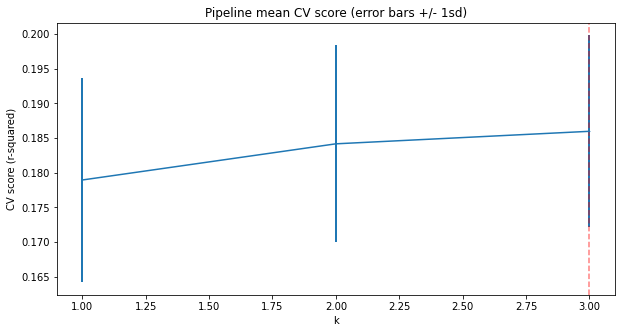

In [143]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Linear Model From Player Ranking-Derived Features Metrics

#### R-squared (COD)

In [144]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.18598396, 0.16593072, 0.1892886 , 0.18007517, 0.20857901])

In [145]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.18597149428735893, 0.013845594469433183)

#### Mean Absolute Error (MAE)

In [146]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [147]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(4.447375980854817, 0.059320408788966085)

In [148]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

4.354790184192748

#### Mean Squared Error (MSE)

In [149]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [150]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(31.32851973687996, 0.6737330704600406)

In [151]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

30.493340346994017

#### Root Mean Square Error (RMSE)

In [152]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [153]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(5.596866460785084, 0.06004629063494603)

In [154]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

5.5220775390240595

### Best Linear Model Feature Importance

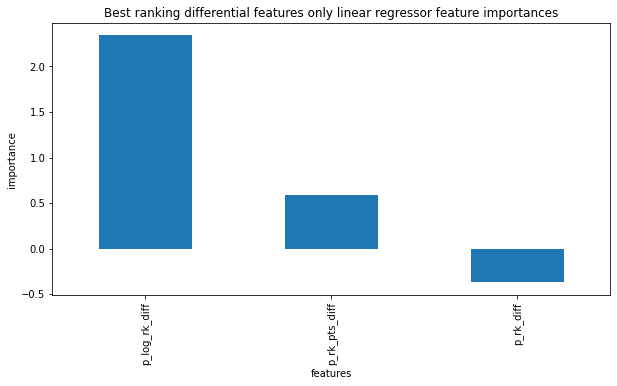

In [155]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best ranking differential features only linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [156]:
# save the best linear model
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
save_file(best_model, 'ranking_linearmodel_hard.pkl', modelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../models\ranking_linearmodel_hard.pkl"


### Save Prediction Metrics from Dummy and Ranking Data-Derived Linear Regression Models

In [157]:
# save other data for model comparisons in machine learning model stage
comp_data_from4_ranking_hard = (MAEs_dummy, MSEs_dummy, RMSEs_dummy, MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
with open('../data/comp_data_from4_ranking_hard.pickle', 'wb') as f:
    pickle.dump(comp_data_from4_ranking_hard, f)

## Benchmark Linear Model Based on Aggregate Closing Line Data

### Train Test Split

In [158]:
len(df_model2) * .75, len(df_model2) * .25

(8241.0, 2747.0)

In [159]:
X_train, X_test, y_train, y_test = train_test_split(df_model2.drop(columns='p_tot_pts_won%'), 
                                                    df_model2["p_tot_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [160]:
y_train.shape, y_test.shape

((8241,), (2747,))

In [161]:
y_train

8865     45.63
19714    54.23
14527    47.69
20835    48.94
11437    47.39
         ...  
6148     55.83
20959    45.27
15868    54.64
4862     54.94
11655    45.65
Name: p_tot_pts_won%, Length: 8241, dtype: float64

In [162]:
X_train.shape, X_test.shape

((8241, 1), (2747, 1))

In [163]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8241 entries, 8865 to 11655
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   p_AVG_C_IP  8239 non-null   float64
dtypes: float64(1)
memory usage: 128.8 KB


In [164]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [165]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [166]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [167]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [168]:
#Conduct grid search for this IWP-restricted model. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000002204554E310>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [169]:
#Best params from grid search for this IWP-restricted model
lr_grid_cv.best_params_

{'selectkbest__k': 1,
 'simpleimputer__strategy': 'median',
 'standardscaler': StandardScaler()}

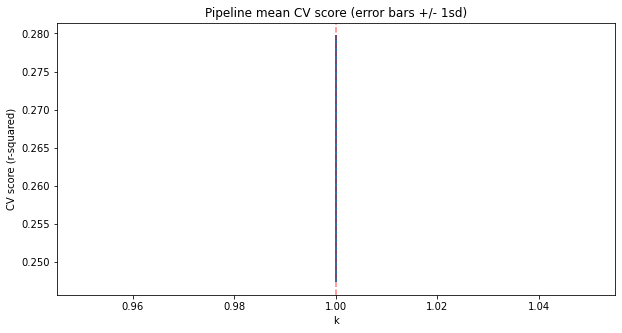

In [170]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Linear Model From IWP (Closing) Features Performance Metrics

#### R-squared (COD)

In [171]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.23990683, 0.25108997, 0.27285609, 0.26805164, 0.2857565 ])

In [172]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.26353220809416944, 0.016212631101737533)

#### Mean Absolute Error (MAE)

In [173]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [174]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(4.170366219263833, 0.027737134496937224)

In [175]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

4.030926127892766

#### Mean Squared Error (MSE)

In [176]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [177]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(28.33908050819531, 0.5213026105376808)

In [178]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

26.885134387165515

#### Root Mean Square Error (RMSE)

In [179]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [180]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(5.323220909987259, 0.048986239595699026)

In [181]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

5.1850876932956025

### Best Linear Model Feature Importance

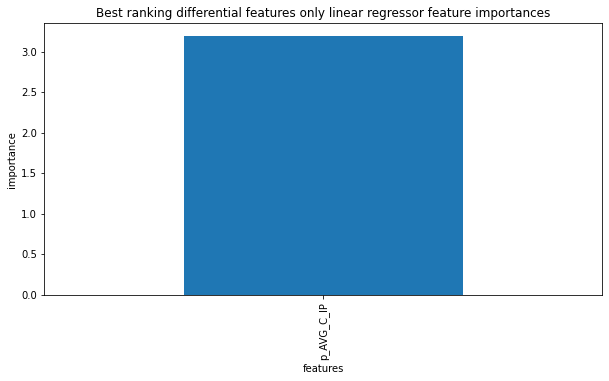

In [182]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best ranking differential features only linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [183]:
# save the best linear model
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
save_file(best_model, 'IWP_C_linearmodel_hard.pkl', modelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../models\IWP_C_linearmodel_hard.pkl"


### Save Prediction Metrics from IWP (Closing) Linear Regression Models

In [184]:
# save other data for model comparisons in machine learning model stage
comp_data_from4_IWP_C = (MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
with open('../data/comp_data_from4_IWP_C_hard.pickle', 'wb') as f:
    pickle.dump(comp_data_from4_IWP_C, f)

## Benchmark Linear Model Based on Closing Line Data (Pinnacle Sports Only)

In [185]:
len(df_model3) * .75, len(df_model3) * .25

(8241.0, 2747.0)

In [186]:
X_train, X_test, y_train, y_test = train_test_split(df_model3.drop(columns='p_tot_pts_won%'), 
                                                    df_model3["p_tot_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [187]:
y_train.shape, y_test.shape

((8241,), (2747,))

In [188]:
y_train

8865     45.63
19714    54.23
14527    47.69
20835    48.94
11437    47.39
         ...  
6148     55.83
20959    45.27
15868    54.64
4862     54.94
11655    45.65
Name: p_tot_pts_won%, Length: 8241, dtype: float64

In [189]:
X_train.shape, X_test.shape

((8241, 1), (2747, 1))

In [190]:
y_train

8865     45.63
19714    54.23
14527    47.69
20835    48.94
11437    47.39
         ...  
6148     55.83
20959    45.27
15868    54.64
4862     54.94
11655    45.65
Name: p_tot_pts_won%, Length: 8241, dtype: float64

In [191]:
X_train.shape, X_test.shape

((8241, 1), (2747, 1))

In [192]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8241 entries, 8865 to 11655
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   p_PS_C_IP  8227 non-null   float64
dtypes: float64(1)
memory usage: 128.8 KB


In [193]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [194]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [195]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [196]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [197]:
#Conduct grid search for this IWP-restricted (Pinnacle only closing lines) model. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000002204554E310>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [198]:
#Best params from grid search for this IWP-restricted (Pinnacle only closing lines) model. 
lr_grid_cv.best_params_

{'selectkbest__k': 1,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

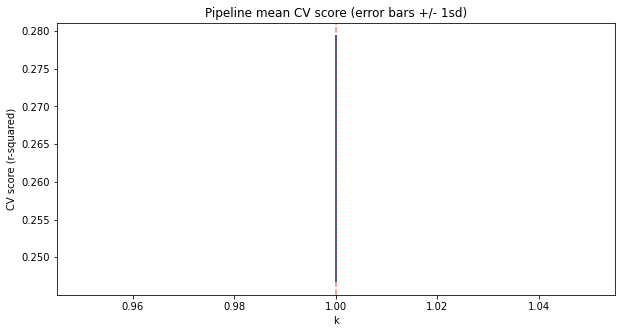

In [199]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Linear Model From IWP (Pinnacle Closing Lines) Features Performance Metrics

#### R-squared (COD)

In [200]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.23942505, 0.24986491, 0.27461745, 0.2667431 , 0.28454537])

In [201]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.2630391756222578, 0.016379743526018477)

#### Mean Absolute Error (MAE)

In [202]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [203]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(4.171050278444744, 0.02822318314625952)

In [204]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

4.039830864194269

#### Mean Squared Error (MSE)

In [205]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [206]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(4.171050278444744, 0.02822318314625952)

In [207]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

26.988710279892004

#### Root Mean Square Error (RMSE)

In [208]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [209]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(5.324961293703173, 0.04573637929318454)

In [210]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

5.195065955297585

### Best Linear Model Feature Importance

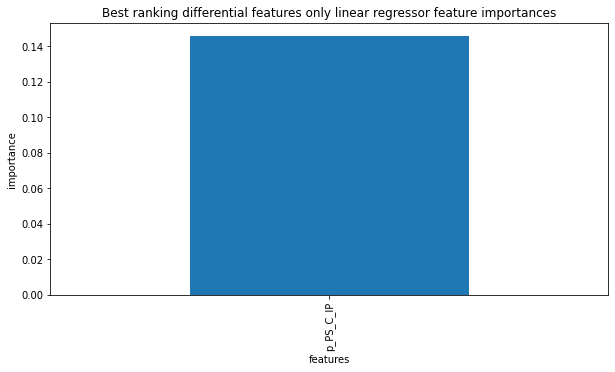

In [211]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best ranking differential features only linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [212]:
# save the best linear model
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
save_file(best_model, 'IWP_PINNY_C_linearmodel_hard.pkl', modelpath)

Writing file.  "../models\IWP_PINNY_C_linearmodel_hard.pkl"


In [213]:
# save other data for model comparisons in machine learning model stage
comp_data_from4_IWP_PINNY_C = (MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
with open('../data/comp_data_from4_IWP_PINNY_C_hard.pickle', 'wb') as f:
    pickle.dump(comp_data_from4_IWP_PINNY_C, f)

## Benchmark Linear Model Based on Opening Line Data (Pinnacle Sports Only)

### Train Test Split

In [214]:
len(df_model4) * .75, len(df_model4) * .25

(8241.0, 2747.0)

In [215]:
X_train, X_test, y_train, y_test = train_test_split(df_model4.drop(columns='p_tot_pts_won%'), 
                                                    df_model4["p_tot_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [216]:
y_train.shape, y_test.shape

((8241,), (2747,))

In [217]:
y_train

8865     45.63
19714    54.23
14527    47.69
20835    48.94
11437    47.39
         ...  
6148     55.83
20959    45.27
15868    54.64
4862     54.94
11655    45.65
Name: p_tot_pts_won%, Length: 8241, dtype: float64

In [218]:
X_train.shape, X_test.shape

((8241, 1), (2747, 1))

In [219]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8241 entries, 8865 to 11655
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   p_PS_O_IP  8216 non-null   float64
dtypes: float64(1)
memory usage: 128.8 KB


In [220]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [221]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [222]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [223]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [224]:
#Conduct grid search for this IWP-restricted (opening lines) model. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000002204554E310>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [225]:
#Best params from grid search for this IWP-restricted model
lr_grid_cv.best_params_

{'selectkbest__k': 1,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

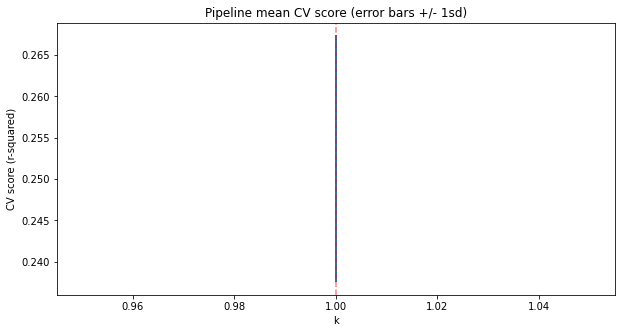

In [226]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Linear Model From IWP (Pinnacle Opening Lines) Features Performance Metrics

#### R-squared (COD)

In [227]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.23223849, 0.24508371, 0.2596173 , 0.24855715, 0.2767053 ])

In [228]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.2524403888729676, 0.014950656400118974)

#### Mean Absolute Error (MAE)

In [229]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [230]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(4.211740622755253, 0.037771284774449534)

In [231]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

4.06061963170181

#### Mean Squared Error (MSE)

In [232]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [233]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(28.76658380636191, 0.5031434422495453)

In [234]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

27.214556247875958

#### Root Mean Square Error (RMSE)

In [235]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [236]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(5.363244080641314, 0.0468693698251834)

In [237]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

5.216757254068465

### Best Linear Model Feature Importance

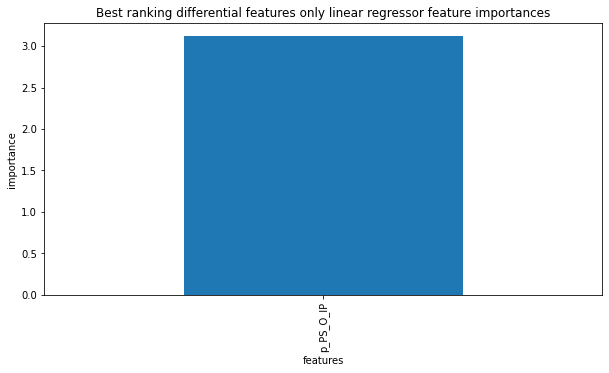

In [238]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best ranking differential features only linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [239]:
# save the best linear model
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
save_file(best_model, 'IWP_PINNY_O_linearmodel_hard.pkl', modelpath)

Writing file.  "../models\IWP_PINNY_O_linearmodel_hard.pkl"


In [240]:
# save other data for model comparisons in machine learning model stage
comp_data_from4_IWP_PINNY_O = (MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
with open('../data/comp_data_from4_IWP_PINNY_O_hard.pickle', 'wb') as f:
    pickle.dump(comp_data_from4_IWP_PINNY_O, f)

### Conclusions

So a simple linear model including only ranking and ranking derivative information outperformed the "dummy" model (RMSE,STD when applicable): 

* Dummy Model: 6.21% Train; 6.11% Test
* Linear Model Using Ranking Data Only: 6.06% (.10%) Train; 6.12% Test
* Linear Model Using IWPs from Aggregate Closing Lines: 5.32% (.05%) Train; 5.19% Test
* Linear Model Using IWPs from Pinnacle Closing Lines: 5.32% (.05%) Train; 5.20% Test
* Linear Model Using IWPs from Pinnacle Opening Lines: 5.36% (.04%); 5.22% Test